# WIYN 2017A Observation Plan

## Top-Level Goals

* Get line-widths for 4-ish face-on spirals
* Dithered observations to get better spatial resolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import cycler

from astropy import table as t, units as u, constants as c, time
from astropy.io import fits
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from astropy.time import Time
from astropy.wcs import WCS

In [2]:
import astroplan as ap
import astroquery as aq

import os, sys
if os.environ['MANGA_CONFIG_LOC'] not in sys.path:
    sys.path.append(os.environ['MANGA_CONFIG_LOC'])

import mangarc

if mangarc.tools_loc not in sys.path:
    sys.path.append(mangarc.tools_loc)

# personal
import manga_tools as m

## Set up plotting rcparams

In [3]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 6.
mpl.rcParams['ytick.labelsize'] = 6.
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (4, 3)

## Set up eline catalog

In [4]:
# air wavelengths
elines = {'Ha': 6564.61 * u.AA,
          '[NII]_1': 6549.84 * u.AA,
          '[NII]_2': 6585.23 * u.AA,
          '[SII]_1': 6718.32 * u.AA,
          '[SII]_2': 6732.71 * u.AA}

# Make a mock spectrograph setup

In [5]:
from benchsim import Spectrograph
from solvers import SpectrographEfficiency

In [6]:
grating_props = {
    'sig': 1./316 * u.mm, 'delta': 63.4 * u.deg, 'rf_tr': 'rf'}
orientation_props = {
    'alpha': 68.9 * u.deg, 'm': 8, 'lam_blaze': 7041. * u.AA}
spectrograph_props = {
    'f_coll': 776. * u.mm, 'f_cam': 285. * u.mm, 'coll_beam_width': 152. * u.mm}
slit_props = {
    'w0_phys': .1 * u.mm}
det_props = {
    'npix': 4000, 'lpix': .012 * u.mm, 'RN': 3.4 * u.ct, 'binning': 2}
telescope_props = {
    'D_scope': 3500. * u.mm, 'l_scope': 22004 * u.mm, 'A_scope': 9.6 * u.m**2}

BenchSetup = Spectrograph(
    grating_props=grating_props, spectrograph_props=spectrograph_props,
    orientation_props=orientation_props, det_props=det_props,
    slit_props=slit_props, telescope_props=telescope_props)

EchelleEff = SpectrographEfficiency(BenchSetup)

print('diffracted angle of central wavelength: {:.02f}'.format(BenchSetup.beta0))
print('angular diameter of fiber: {:.02f}'.format(BenchSetup.w0_ang.to(u.arcsec)))
print('solid angle subtended by fiber: {:.02f}'.format(BenchSetup.fiber_grasp))
print('wavelength limits: [{:.02f}, {:.02f}]'.format(*BenchSetup.lam_range))
print('camera-collimator angle: {:.02f}'.format(BenchSetup.cam_coll_angle))

diffracted angle of central wavelength: 57.89 deg
angular diameter of fiber: 0.94 arcsec
solid angle subtended by fiber: 0.69 arcsec2
wavelength limits: [6852.23 Angstrom, 7206.02 Angstrom]
camera-collimator angle: 11.01 deg


<IPython.core.display.Javascript object>


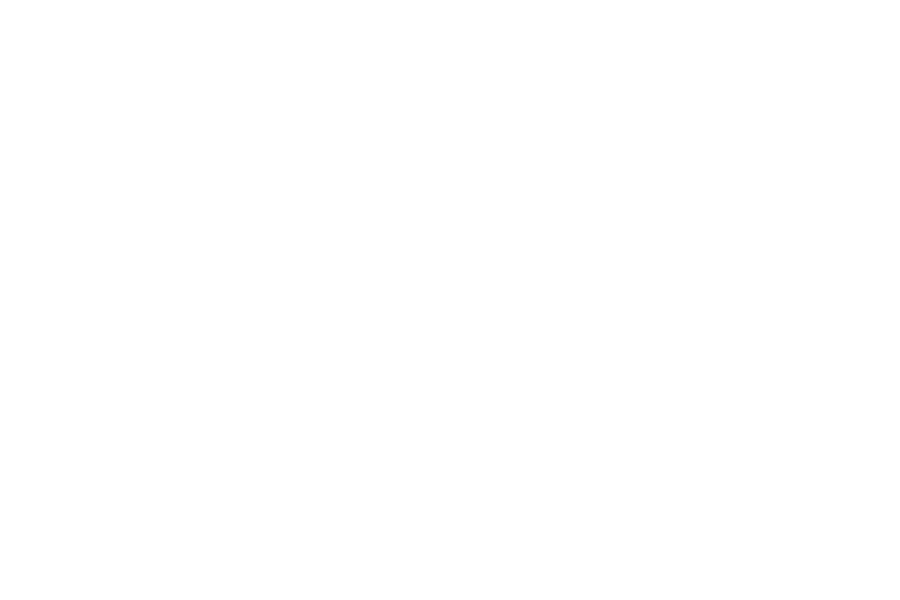

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
axs[0, 0].plot(BenchSetup.wavelengths, BenchSetup.R, 
         label=r'$(\frac{\lambda}{d \lambda})_{{\rm slit}}$')
axs[0, 0].plot(BenchSetup.wavelengths, BenchSetup.wavelengths / BenchSetup.dwavelengths, 
         label=r'$(\frac{\lambda}{d \lambda})_{{\rm pix}}$')
axs[0, 0].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[0, 0].set_ylabel('Spectral Resolution', size=8)
axs[0, 0].legend(prop={'size': 6})

axs[0, 1].plot(BenchSetup.wavelengths, BenchSetup.w_reim_spec / BenchSetup.dwavelengths, 
         label=r'$\frac{{\rm (d \lambda)_{pix}}}{{\rm (d \lambda)_{slit}}}}$')
axs[0, 1].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[0, 1].set_ylabel('Slit width [pix]', size=8)
axs[0, 1].legend(prop={'size': 6})

axs[1, 0].plot(BenchSetup.wavelengths, BenchSetup.dwavelengths)
axs[1, 0].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[1, 0].set_ylabel(r'${\rm d \lambda_{pix}}$', size=8)

axs[1, 1].plot(BenchSetup.wavelengths, BenchSetup.anam)
axs[1, 1].set_xlabel(r'$\lambda {\rm [\AA]}$', size=8)
axs[1, 1].set_ylabel('Anamorphic factor', size=8)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


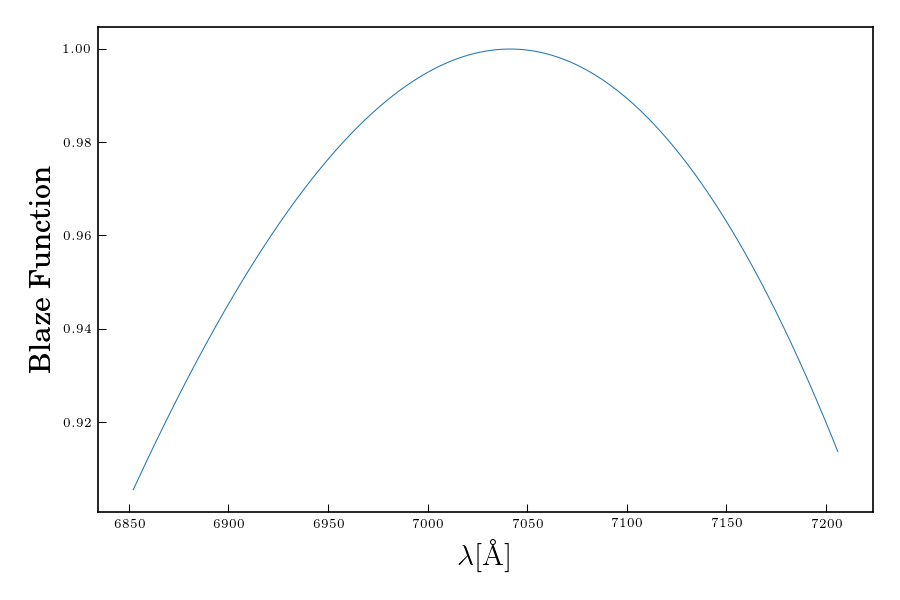

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(BenchSetup.wavelengths, EchelleEff.B(BenchSetup.wavelengths, m=8), linewidth=0.5)
plt.xlabel(r'$\lambda {\rm [\AA]}$')
plt.ylabel('Blaze Function')
plt.tight_layout()
plt.show()

## Compute redshift limits

Accessible redshift range must observe all lines.

In [9]:
lam_lines = np.array([v.value for v in elines.values()]) * elines['Ha'].unit
lam_llim, lam_ulim = BenchSetup.lam_range
def redshift_is_accessible(z, lam_lines=lam_lines, lam_llim=lam_llim, lam_ulim=lam_ulim):
    '''
    returns True if lam_lims encomapsses all wavelengths lam_lines after they have been redshifted by z
    '''
    lam_lines_z = lam_lines + (lam_lines * np.log(1. + z))
    above_lam_llim = (lam_lines_z >= lam_llim)
    below_lam_llim = (lam_lines_z <= lam_ulim)
    return np.all(np.row_stack([above_lam_llim, below_lam_llim]))

_zgrid = np.linspace(0.0, 0.2, 200)
_z_is_accessible = np.array(list(map(redshift_is_accessible, _zgrid)))
good_zs = _zgrid[_z_is_accessible]

zmin = good_zs.min()
zmax = good_zs.max()

print('redshift range: [{:.04f}, {:.04f}]'.format(zmin, zmax))

redshift range: [0.0482, 0.0724]


# Parse the catalog

Start by loading the catalog of objects, and cut non-galaxies.

Also cut low-mass stuff and focus on MW-like disks

In [10]:
drpall = t.Table.read('/usr/data/minhas2/tremonti/manga/mpl5_data/drpall-v2_0_1.fits')
drpall = drpall[drpall['nsa_z'] != -9999.]
drpall.add_index('plateifu')
print(drpall.colnames)

['plate', 'ifudsgn', 'plateifu', 'mangaid', 'versdrp2', 'versdrp3', 'verscore', 'versutil', 'versprim', 'platetyp', 'srvymode', 'objra', 'objdec', 'ifuglon', 'ifuglat', 'ifura', 'ifudec', 'ebvgal', 'nexp', 'exptime', 'drp3qual', 'bluesn2', 'redsn2', 'harname', 'frlplug', 'cartid', 'designid', 'cenra', 'cendec', 'airmsmin', 'airmsmed', 'airmsmax', 'seemin', 'seemed', 'seemax', 'transmin', 'transmed', 'transmax', 'mjdmin', 'mjdmed', 'mjdmax', 'gfwhm', 'rfwhm', 'ifwhm', 'zfwhm', 'mngtarg1', 'mngtarg2', 'mngtarg3', 'catidnum', 'plttarg', 'manga_tileid', 'nsa_iauname', 'ifudesignsize', 'ifutargetsize', 'ifudesignwrongsize', 'zmin', 'zmax', 'szmin', 'szmax', 'ezmin', 'ezmax', 'nsa_field', 'nsa_run', 'nsa_camcol', 'nsa_version', 'nsa_nsaid', 'nsa_nsaid_v1b', 'nsa_z', 'nsa_zdist', 'nsa_sersic_absmag', 'nsa_elpetro_absmag', 'nsa_elpetro_amivar', 'nsa_sersic_mass', 'nsa_elpetro_mass', 'nsa_elpetro_ba', 'nsa_elpetro_phi', 'nsa_extinction', 'nsa_elpetro_th50_r', 'nsa_petro_th50', 'nsa_petro_flux',

<IPython.core.display.Javascript object>


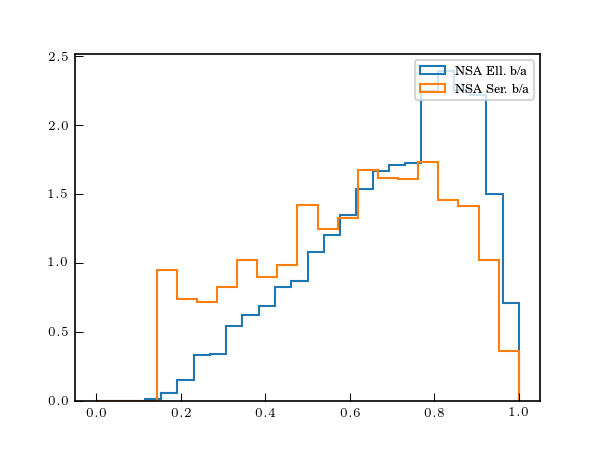

In [11]:
plt.figure()
plt.hist(drpall['nsa_elpetro_ba'], range=[0., 1.], bins='auto', histtype='step', label='NSA Ell. b/a', normed=True)
plt.hist(drpall['nsa_sersic_ba'], range=[0., 1.], bins='auto', histtype='step', label='NSA Ser. b/a', normed=True)
plt.legend(prop={'size': 6.})
plt.show()

In [12]:
cat = drpall
cat = cat[(cat['nsa_z'] >= zmin) * (cat['nsa_z'] <= zmax)]
cat = cat[cat['ifudesignsize'] >= 91]

cat['logmstar'] = np.log10(cat['nsa_sersic_mass'])

cat = cat[cat['logmstar'] > 9.5]
cat = cat[(cat['nsa_sersic_absmag'][:, 3] - cat['nsa_sersic_absmag'][:, 4]) < .7]
cat = cat[cat['nsa_elpetro_th50_r'] > (2. * BenchSetup.w0_ang.to(u.arcsec).value)]
cat = cat[cat['nsa_sersic_ba'] > 0.7]
cat.sort('nsa_elpetro_th50_r')

print(cat['mangaid', 'plateifu', 'nsa_elpetro_th50_r', 'logmstar', 'nsa_z'])

mangaid   plateifu  nsa_elpetro_th50_r    logmstar     nsa_z  
-------- ---------- ------------------ ------------- ---------
1-234341  8319-9101            4.10835 10.6327598768 0.0706991
1-259050  8341-9101            4.30496 10.3337252952 0.0512136
 1-44634  8718-9101            4.42475 10.1461993782 0.0502249
1-351622  8567-9102            4.60121 10.4334353864 0.0585982
1-147522  8453-9102            4.62109 10.6701298401 0.0653628
 1-44083  8141-9102            4.99938 10.0221973459 0.0504328
1-260733 8447-12701            5.07741 10.1779489559 0.0507247
1-113587 8618-12704            5.08098 10.6124574836 0.0704926
12-84674 7443-12702            5.28583 10.4127796408 0.0575241
1-548080 8239-12705            5.54693  10.339944091 0.0513668
     ...        ...                ...           ...       ...
1-274244 8568-12703             6.5311 10.1344862968 0.0528405
1-487130  8448-9101            6.58612 10.4541479061 0.0586842
 1-91760 8481-12704            6.78311 10.5269863592 0.

In [13]:
coords = SkyCoord(cat['objra'] * u.deg, cat['objdec'] * u.deg)
coordfile_text = [' '.join((n, c)) for c, n in zip(coords.to_string('decimal'), cat['plateifu'])]

with open('coordfile.txt', 'w') as f:
    f.write('\n'.join(coordfile_text))

## What wavelengths are we interested in?

In [14]:
targ_elines = cat['plateifu', 'nsa_z', 'logmstar']

for k in elines.keys():
    targ_elines[k] = np.log(1. + targ_elines['nsa_z']) * elines[k] + elines[k]
    
lmin = targ_elines['[NII]_1', '[NII]_2', '[SII]_1', '[SII]_2', 'Ha'].as_array().view((float, len(elines))).min(axis=1)
lmax = targ_elines['[NII]_1', '[NII]_2', '[SII]_1', '[SII]_2', 'Ha'].as_array().view((float, len(elines))).max(axis=1)
    
targ_elines['lmin'] = lmin * u.AA
targ_elines['lmax'] = lmax * u.AA
targ_elines.sort('lmin')

# Plot the downselected catalog

<IPython.core.display.Javascript object>


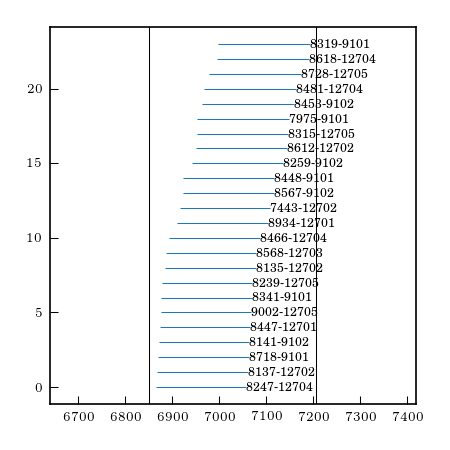

In [15]:
fig_ht = 2.5 * (len(cat) / 20.)
plt.figure(figsize=(3., fig_ht))
ax = plt.gcf().add_subplot(111)
ax = BenchSetup.lam_range_plot(ax)

ax.errorbar(
    targ_elines['Ha'], np.array(range(len(targ_elines))),
    xerr=[(targ_elines['Ha'] - targ_elines['lmin']),
          (targ_elines['lmax'] - targ_elines['Ha'])], markersize=4.,
    linestyle='None', linewidth=0.5)

xloc = targ_elines['lmax']
for i, row in enumerate(targ_elines):
    ax.text(row['lmax'], i - 0.25, row['plateifu'], size=6.)

plt.tight_layout()
plt.show()

Set up fiducial models for galaxies

In [16]:
# extract Ha flux map, and change to Ha surface brightness
def emline_SB(dap, key, snr_min=3.):
    el_f_hdu = dap['EMLINE_GFLUX']
    el_f_iv_hdu = dap['EMLINE_GFLUX_IVAR']
    
    # get a mapping from eline key to channel key
    v2k = {v: k for (k, v) in el_f_hdu.header.items()}
    # get a mapping from channel key to channel
    cstring2ix = lambda s: int(s[1:]) - 1
    
    ix = cstring2ix(v2k[key])
    
    # flux and ivar
    f = el_f_hdu.data[ix, ...]
    f_ivar = el_f_iv_hdu.data[ix, ...]
    
    # SNR minimum
    snr = f * np.sqrt(f_ivar)
    f_mask = (snr < snr_min)
    
    # units for bin area and flux ==> surface brightness
    bin_area = dap['BIN_AREA'].data * u.arcsec**2.
    f_unit = u.Unit('1e-17 erg s-1 cm-2')
    SB_unit = f_unit / bin_area
    
    return f * SB_unit, f_mask

from astropy.wcs.utils import skycoord_to_pixel, proj_plane_pixel_scales, custom_frame_mappings

def make_wcs_offset(dap):
    # load dummy HDU
    hdu = dap['SPX_MFLUX']
    
    # un-offset WCS header
    wcs_orig = WCS(hdu.header)
    
    origin = SkyCoord(
        ra=dap[0].header['IFURA'] * u.deg, dec=dap[0].header['IFUDEC'] * u.deg)
    wcs_new = origin.skyoffset_frame()

    return wcs_new

angle_to_imgpos = lambda p, n, ctr: tuple((nn / 2. + ((pp - cc) / pixscale)).value for pp, nn, cc in zip(p, n, ctr))

# generate rotation matrix
rotmatrix = lambda a: np.array([[np.cos(a), -np.sin(a)], 
                                [np.sin(a),  np.cos(a)]])

def ifu_overlay(astrometry_tab, ifu_ctr, ax, dither=None, offset=None, **kwargs):
    '''
    put a HexPak IFU overlay defined in `astrometry_tab` and with center location
        `ifu_ctr` atop image on axes `ax`
        
    `offset` is a pure-spatial (array-like) specification of a dither pattern, `dither` is
        an array-like specification with an offset of `dither[0]` at angle `dither[1]`
        CCW from East
    '''
    if (dither is None) and (offset is None):
        offset = [0. * u.arcsec, 0. * u.arcsec]
    elif (dither is not None) and (offset is not None):
        raise ValueError('don\'t specify both offset (spatial) and dither (angular-radial)')
    elif dither is not None:
        offset = np.array([1., 0.]) * dither[0]
        offset = offset.dot(rotmatrix(dither[1]))
    elif offset is not None:
        pass
    
    for row in astrometry_tab:
        fib_ctr = [row['d_alpha'] * u.deg, row['d_delta'] * u.deg]
        fib_ctr = [(v1 + v2).to(u.deg) for v1, v2 in zip(fib_ctr, offset)]
        X, Y = angle_to_imgpos(p=fib_ctr, n=Ha_map.shape, ctr=ifu_ctr)
        R = (row['R'] * u.arcsec / pixscale).value
        ax.add_artist(Circle((X, Y), R, **kwargs))
    
    return ax

In [17]:
# read in HexPak astrometry table
HexPak_astrometry = t.Table.read('hexpak_overlay.dat', format='ascii', delimiter=' ')
HexPak_astrometry['d_alpha'][HexPak_astrometry['d_alpha'] > 180.] -= 360.
#print(HexPak_astrometry)

ctr_row = HexPak_astrometry[84]
ifu_ctr = [ctr_row['d_alpha'] * u.deg, ctr_row['d_delta'] * u.deg]

lower_innercore_row = HexPak_astrometry[86]

# define standard dither offsets for inner core
d_innercore = np.abs(ctr_row['d_delta'] - lower_innercore_row['d_delta']) * u.deg
d_outer = (3.806 * u.arcsec).to(u.deg)

/usr/data/minhas/zpace/miniconda3/envs/obsplan/lib/python3.5/site-packages/astropy/units/quantity.py:951: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/usr/data/minhas/zpace/miniconda3/envs/obsplan/lib/python3.5/site-packages/astropy/units/quantity.py:924: RuntimeWarning: invalid value encountered in multiply
  return super(Quantity, self).__mul__(other)


<IPython.core.display.Javascript object>


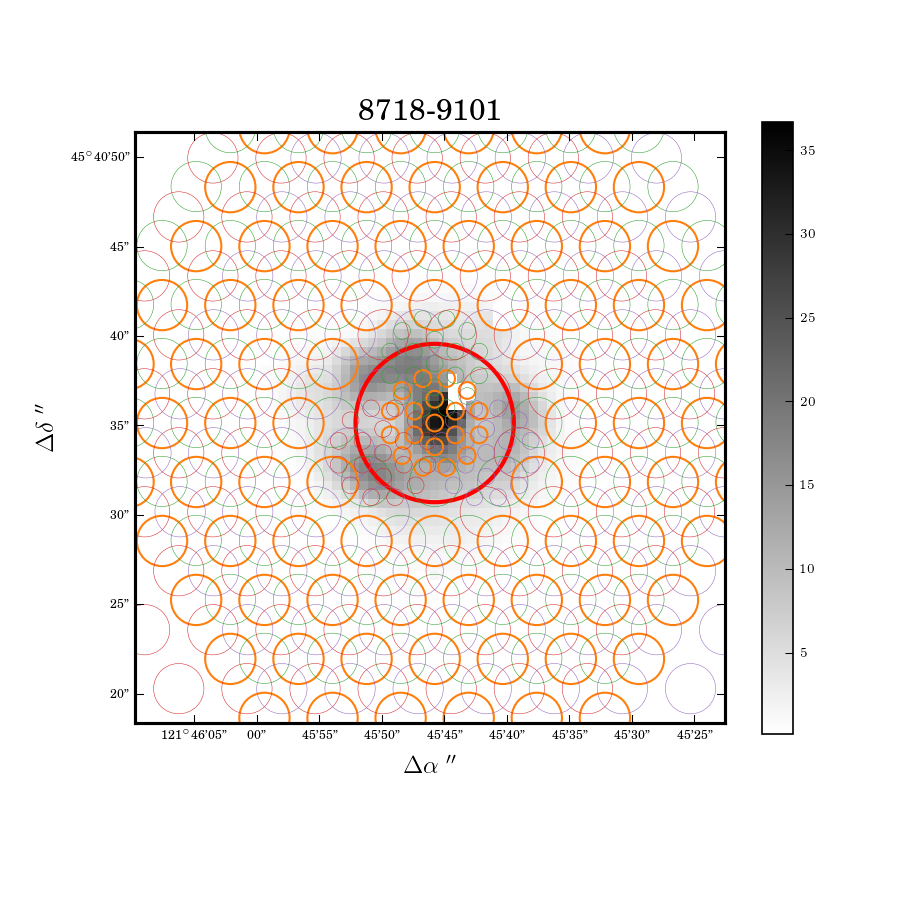

In [18]:
# fiber overlay
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle

# select object
row_ = cat[2]
plateifu = row_['plateifu']
row = cat.loc[plateifu]
pixscale = 0.5 * u.arcsec
coresize = 3. * BenchSetup.w0_ang.to(u.arcsec)
ifusize = 40.85 * u.arcsec

# load MAPS
dap = m.load_dap_maps(plate=str(row['plate']), ifu=str(row['ifudsgn']), mpl_v='MPL-5', kind='SPX-GAU-MILESHC')

# prepare Ha SB map
obj_ctr = SkyCoord(ra=dap[0].header['OBJRA'] * u.deg, dec=dap[0].header['OBJDEC'] * u.deg)
wcs_orig = WCS(dap['SPX_MFLUX'].header)
wcs_offset = make_wcs_offset(dap)
Ha_map, Ha_map_mask = emline_SB(dap, key='Ha-6564')

try:
    plt.close(fig)
except:
    pass

# make figure
fig = plt.figure(figsize=(6., 6.))
ax = fig.add_subplot(111, projection=wcs_orig)
im = ax.imshow(np.ma.array(Ha_map.value, mask=Ha_map_mask), aspect='equal', cmap='binary')
plt.colorbar(im, ax=ax, shrink=0.8)

ax.set_xlabel(' '.join((r'$\Delta \alpha$', u.arcsec._repr_latex_())))
ax.set_ylabel(' '.join((r'$\Delta \delta$', u.arcsec._repr_latex_())))
ax.set_title(row['plateifu'])


# plot 1 Re
Re = row['nsa_elpetro_th50_r']
ax.add_patch(Circle(tuple(map(lambda x: x / 2., Ha_map.shape)), 
                    (Re / pixscale).value, facecolor='None', edgecolor='r', linewidth=2.))

# center position
ifu_overlay(astrometry_tab=HexPak_astrometry, ifu_ctr=ifu_ctr, ax=ax,
            facecolor='None', edgecolor='C1', linewidth=1.)
# dithers
ifu_overlay(astrometry_tab=HexPak_astrometry, ifu_ctr=ifu_ctr, ax=ax,
            dither=[5. * d_innercore / 2., 270. * u.deg],
            facecolor='None', edgecolor='C2', linewidth=0.25)
ifu_overlay(astrometry_tab=HexPak_astrometry, ifu_ctr=ifu_ctr, ax=ax,
            dither=[5. * d_innercore / 2., 150. * u.deg],
            facecolor='None', edgecolor='C3', linewidth=0.25)
ifu_overlay(astrometry_tab=HexPak_astrometry, ifu_ctr=ifu_ctr, ax=ax,
            dither=[5. * d_innercore / 2., 30. * u.deg],
            facecolor='None', edgecolor='C4', linewidth=0.25)

for i in range(2):
    ax.coords[i].set_ticklabel(size=6.)
    ax.coords[i].set_ticks(spacing=5. * u.arcsec)
    ax.coords[i].set_format_unit(u.arcsec)

fig.tight_layout()
fig.subplots_adjust(left=0.15, bottom=0.1, top=0.95)
fig.show()

# Transmission by various components

<IPython.core.display.Javascript object>


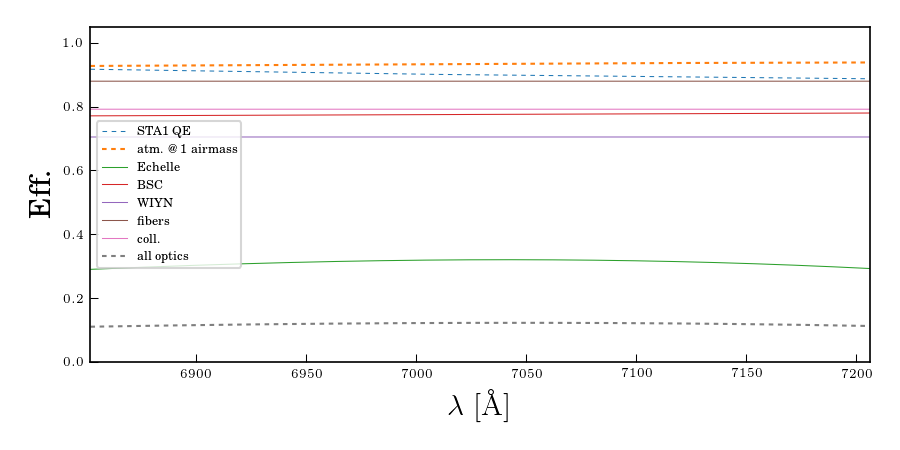

In [24]:
# efficiency curves
from scipy.interpolate import interp1d

# detector
STA1_QE = interp1d(x=np.linspace(3000., 11000., 15) * u.AA,
                   y=np.array([.485, .747, .777, .818, .905, .987, .962,
                               .902, .862, .791, .685, .523, .357, .09, .02]),
                   kind='linear', bounds_error=False, fill_value=0.)

# camera
SimCam_tr = lambda l: .45 * np.ones_like(l)
BSC_tr = interp1d(x=np.array([3800., 4000., 8000., 11000.]) * u.AA,
                  y=np.array([.45, .7, .8, .7]),
                  kind='linear', bounds_error=False, fill_value=0.)

# grating
grating_eff = lambda l: 0.32 * EchelleEff.B(l, BenchSetup.m)
#grating_eff = lambda l: 0.32 * 0.89 * np.ones_like(l)

# collimator (reflectance + vignetting)
# Bershady et al 05
coll_tr = lambda l: .89**2. * np.ones_like(l)

# fibers
# Bershady et al 05
fiber_tr = lambda l: .88 * np.ones_like(l)

# telescope
WIYN_tr = lambda l: .89**3. * np.ones_like(l)

# total instrument efficiency
optics_eff = lambda l: WIYN_tr(l) * fiber_tr(l) * coll_tr(l) * grating_eff(l) * BSC_tr(l)

# atmosphere
atm_lam = np.array([6435., 6790., 7100., 7550., 7780.])
atm_mag = np.array([.104, 0.084, 0.071, 0.061, 0.055])
atm_tr = interp1d(x=atm_lam, y=10.**(-0.4 * atm_mag),
                  kind='linear', bounds_error=False, fill_value=0.)

plt.figure(figsize=(6, 3))

eff_lam = BenchSetup.wavelengths

plt.plot(eff_lam, STA1_QE(eff_lam), linewidth=0.5, linestyle=':', label='STA1 QE')
plt.plot(eff_lam, atm_tr(eff_lam), linewidth=1., linestyle=':', label='atm. @ 1 airmass')
plt.plot(eff_lam, grating_eff(eff_lam),
         linewidth=0.5, label='Echelle')
plt.plot(eff_lam, BSC_tr(eff_lam), linewidth=0.5, label='BSC')
plt.plot(eff_lam, WIYN_tr(eff_lam), linewidth=0.5, label='WIYN')
plt.plot(eff_lam, fiber_tr(eff_lam), linewidth=0.5, label='fibers')
plt.plot(eff_lam, coll_tr(eff_lam), linewidth=0.5, label='coll.')

plt.plot(eff_lam, optics_eff(eff_lam), linewidth=1., linestyle=':', label='all optics')

plt.xlim(list(map(lambda x: x.value, BenchSetup.lam_range)))
plt.ylim([0., 1.05])

plt.xlabel(r'$\lambda ~ {\rm [\AA]}$')
plt.ylabel(r'Eff.')

plt.legend(loc='best', prop={'size': 6.})
plt.tight_layout()
plt.show()

# Predict photons received from object at wavelength

Next step: assume some SFR, pull out Ha SB, try to predict S/N

In [20]:
from synthdata import IFUCubeObserver, unc_of_cts

In [21]:
Obsv = IFUCubeObserver.from_drpall_row(row=cat.loc[plateifu], lamlims=BenchSetup.wavelengths,
                                       lspax=(0.5 * u.arcsec), mpl_v='MPL-5')

In [25]:
ix_ctr = (np.median(Obsv.II), np.median(Obsv.JJ))
ix = (20, 20)
spec_cts_rate = Obsv(ctr=ix_ctr, lams=BenchSetup.wavelengths, dlams=BenchSetup.dwavelengths, 
                    D_fib=BenchSetup.w0_ang, effs=[atm_tr, optics_eff, STA1_QE], A_scope=BenchSetup.A_scope,
                    spat_samples=100)
exptime = (60. * u.min)
spec_ct = (spec_cts_rate * exptime).to(u.ct)
spec_ct_unc = unc_of_cts(spec_ct)

<IPython.core.display.Javascript object>


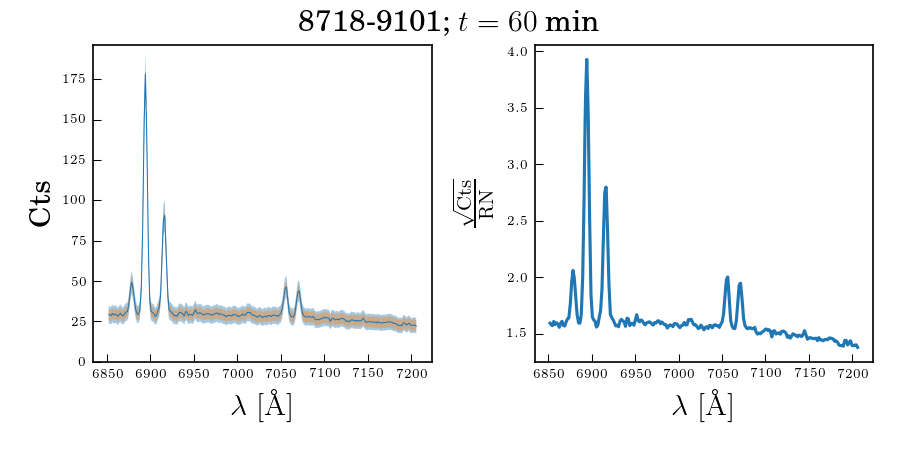

In [26]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.fill_between(x=BenchSetup.wavelengths.value, y1=(spec_ct - spec_ct_unc).value, 
                 y2=(spec_ct + spec_ct_unc).value, alpha=0.4, facecolor='C0')
ax1.fill_between(x=BenchSetup.wavelengths.value, y1=(spec_ct - BenchSetup.RN).value,
                 y2=(spec_ct + BenchSetup.RN).value, alpha=0.4, facecolor='C1')
ax1.plot(BenchSetup.wavelengths.value, spec_ct.value, linewidth=0.5)
ax1.set_ylim([0., 1.1 * spec_ct.value.max()])

ax1.set_xlabel(r'$\lambda ~ [{\rm \AA}]$')
ax1.set_ylabel('Cts')

ax2.plot(BenchSetup.wavelengths, spec_ct_unc / BenchSetup.RN)
ax2.set_xlabel(r'$\lambda ~ [{\rm \AA}]$')
ax2.set_ylabel(r'$\frac{\sqrt{{\rm Cts}}}{{\rm RN}}$')

plt.suptitle(r'{0}; $t = {1.value:.0f} ~ {1.unit:latex}$'.format(cat.loc[plateifu]['plateifu'], exptime))

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()